<a href="https://colab.research.google.com/github/pradnya13-ts/Imperial-Topological-Optimization-and-Machine-Learning/blob/main/notebooks/TO%20Lab%20(a).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TO Lab**
This notebook is developed for educational purposes only.
- Authors: Erin Yu, Sasha Halsey, Amber Wang and Ajit Panesar (IDEA Lab, Imperial College London)
- Version: v1 (16/12/2025)
- Comments and corrections to a.panesar@imperial.ac.uk, sasha.halsey20@imperial.ac.uk
- Based on 'A 99 line topology optimization code written in MATLAB' (https://www.topopt.mek.dtu.dk/apps-and-software/a-99-line-topology-optimization-code-written-in-matlab)

-------------------


# **(a) Topology optimisation algorithm 2D**

### **Table of Contents**

1\) Solve a classic structural optimisation problem: MBB beam

2\) Use a 2D topology optimisation algorithm employing SIMP approach

3\) Find the result after first iteration

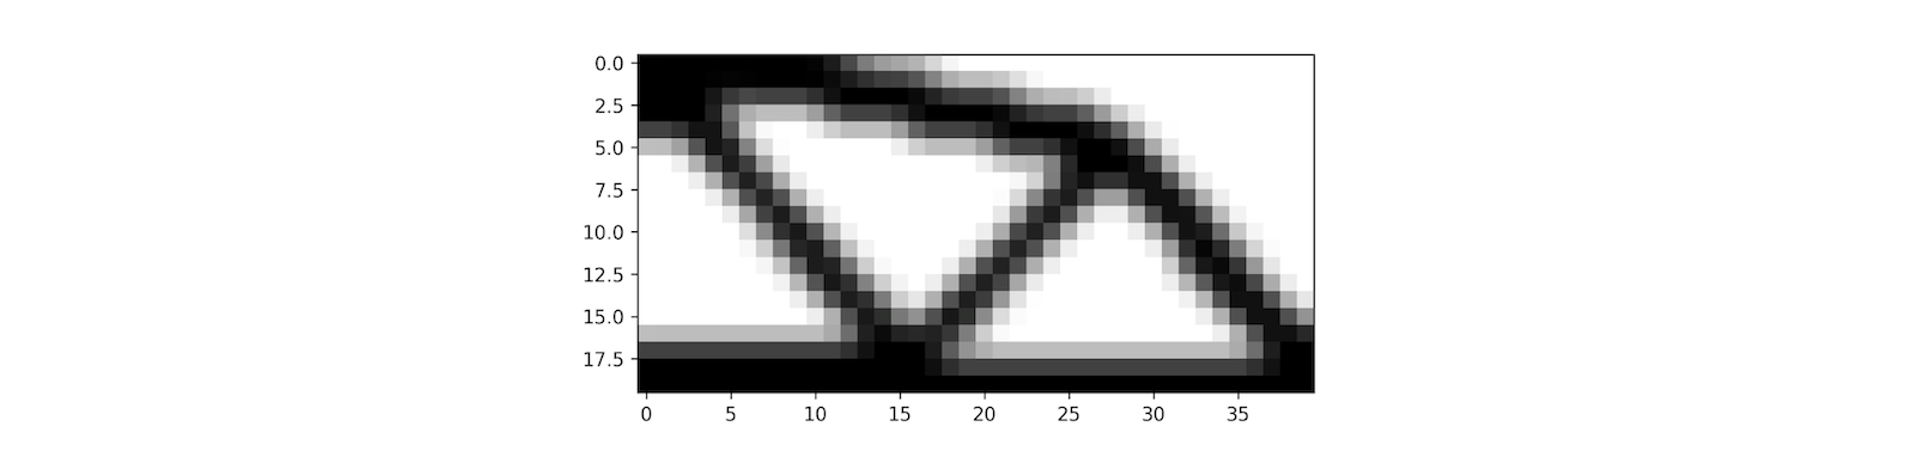

-------------------

###  Import library

Run the cell below to import necessarry python libraries for this lab.

In [1]:
# --- Clone repository from Git
!git clone https://github.com/IDEA-lab-IC/Tutorials.git
%cd Tutorials

from __future__ import division
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from matplotlib import colors
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import spsolve
# pip install matplotlib
# pip install numpy

Cloning into 'Tutorials'...
remote: Enumerating objects: 224, done.
remote: Counting objects: 100% (224/224), done.
remote: Compressing objects: 100% (156/156), done.
remote: Total 224 (delta 156), reused 136 (delta 68), pack-reused 0 (from 0)
Receiving objects: 100% (224/224), 7.39 MiB | 14.99 MiB/s, done.
Resolving deltas: 100% (156/156), done.
/content/Tutorials


-----------
# **1) Problem Context**
### MBB beam
The Messerschmitt–Bölkow–Blohm (MBB) beam is a classic benchmark in structural topology optimisation. Refer to the figure below for the loading and boundary conditions. Due to symmetry, the half MBB beam is commonly utilised for analysis to save computational resources. In this tutorial, the objective is to find the optimal topology of the MBB beam such that the compliance (total strain energy) is minimised while satisfying volume fraction constraint. In literatures, TO problems with other objectives/constraints might also consider stress, displacement, manufacturability, etc.

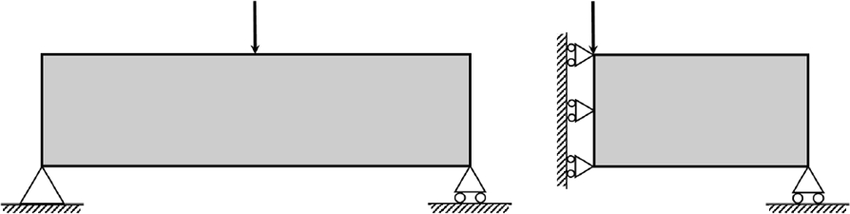

### Optimisation Framework

We solve a density–based topology optimisation problem with the SIMP formulation.

- **Design variable:**  
  Elemental relative density  
  $$ x_e \in [0,1] $$

- **Objective function:**  
  Minimise compliance (maximise stiffness)
  $$
  \min_x\; C(x) = \mathbf{F}^\mathsf{T}\mathbf{U}(x)
  $$
  where the displacement field satisfies  
  $$
  \mathbf{K}(x)\,\mathbf{U}(x) = \mathbf{F}.
  $$

- **Constraint:**  
  Global volume fraction  
  $$
  \frac{1}{N_e}\sum_{e=1}^{N_e} x_e = V^\ast.
  $$


### SIMP Approach

SIMP approach (Solid Isotropic Material with Penalisation), also known as the power law approach, is one of the most widely used method in Topology Optimisation. "Here, material properties are assumed constant within each element used to discretise the design domain and the variables are the element relative densities. The material properties are modelled as the relative material density raised to some power times the material properties of solid material."

$E(x) = E_{\min} + x^p (E_{\max} - E_{\min})$

- $E(x)$: elemental material property  
- $x$: elemental relative density (design variable)  
- $p$: penalty exponent (typically $p = 3$ in most literatures.)  
- $E_{\min}$: void stiffness (very small positive value for numerical stability)  
- $E_{\max}$: solid stiffness  

The code below allows you to explore the influence of the penalty on the relative stiffness. Higher penalty implies more significant penalisation on intermediate relative density values.

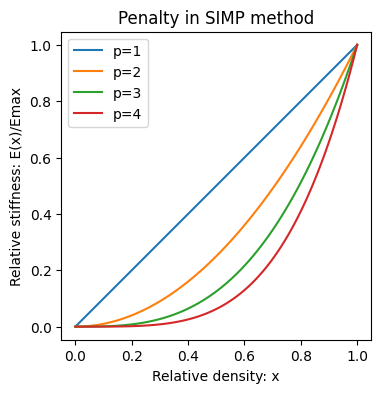

In [2]:
# Define constants & design variables
Emin=1e-9
Emax=1.0
p_values = [1, 2, 3, 4]
x_values = np.linspace(0, 1, 100)

# Plotting
plt.figure(figsize=(4, 4))
for p in p_values:
    E_values = Emin + (x_values ** p) * (Emax - Emin)
    plt.plot(x_values, E_values, label=f'p={p}')

plt.title('Penalty in SIMP method')
plt.xlabel('Relative density: x')
plt.ylabel('Relative stiffness: E(x)/Emax')
plt.axis('equal')
plt.grid(False)
plt.legend()
plt.show()

----------

# **2) Steps of Topology Optimisation**
## **2.1) Input parameters**
You are able to discritise the design domain by defining the number of elements in x and y direction (nelx, nely). More elements will lead to higher resolution but also increasing computational time. You can define a target volume fraction of the final topology relative to the entire design domain (volfrac). In SIMP approach, intermediate density will be penalised (penal). To avoid checkboard pattern, filtering scheme will be applied (rmin).

In [ ]:
nelx=3
nely=2
volfrac=0.3
penal=3
rmin=1

print(f"Number of elements in the x-direction: {nelx}")
print(f"Number of elements in the y-direction: {nely}")
print(f"Targeted volume fraction: {volfrac}")
print(f"Penalty: {penal}")
print(f"Filter radius: {rmin}")

Number of elements in the x-direction: 3
Number of elements in the y-direction: 2
Targeted volume fraction: 0.3
Penalty: 3
Filter radius: 1


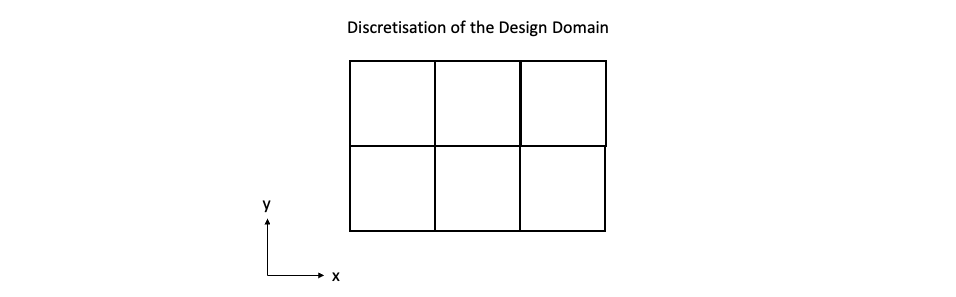

## **2.2) Initialisation**
### Define material properties
- Young's modulus ($E$): the ratio between stress (force per unit area) and the resulting axial strain (change in length over the original length). It measures the stiffness of a material.
- Poisson's ratio ($v$): the ratio between transverse strain and axial strain. Elongation in the axial direction usually lead to compression in the transverse direction. Poisson's ratio is defined as a postive number.

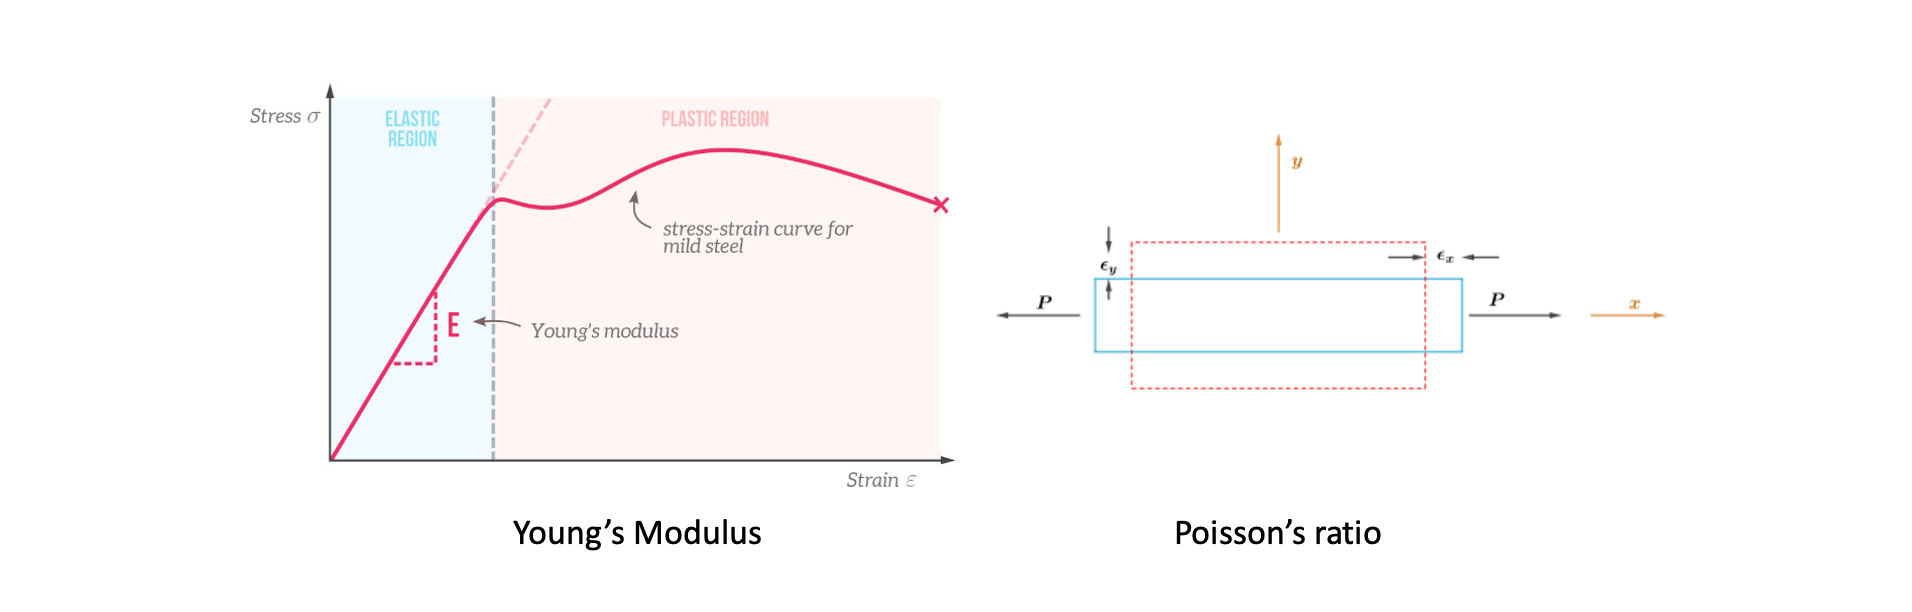

In [ ]:
Emin=1e-9   # Min stiffness. Assume a very small number rather than zero to ensure numerical stability
Emax=1.0    # Max stiffness. Normailised to 1.
nu=0.3      # Poisson's ratio

### Elemental stiffness matrix [$Ke$]
The finite element type chosen is 4-noded quadrilateral. As the name suggested, there are four nodes, each with two translational degree of freedom (in x and y direction, respectively), resulting in a 8 by 8 elemental stiffness matrix. Each term of the stiffness matrix is a function of the Young's Modulus ($E$) and Poisson's ratio ($v$).

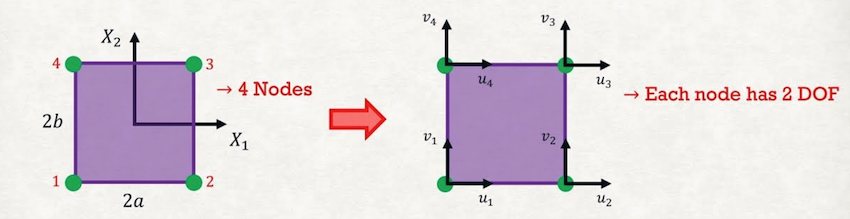

In [ ]:
# Function: element stiffness matrix
def lk():
    E=1
    nu=0.3
    k=np.array([1/2-nu/6,1/8+nu/8,-1/4-nu/12,-1/8+3*nu/8,-1/4+nu/12,-1/8-nu/8,nu/6,1/8-3*nu/8])
    KE = E/(1-nu**2)*np.array([ [k[0], k[1], k[2], k[3], k[4], k[5], k[6], k[7]],
    [k[1], k[0], k[7], k[6], k[5], k[4], k[3], k[2]],
    [k[2], k[7], k[0], k[5], k[6], k[3], k[4], k[1]],
    [k[3], k[6], k[5], k[0], k[7], k[2], k[1], k[4]],
    [k[4], k[5], k[6], k[7], k[0], k[1], k[2], k[3]],
    [k[5], k[4], k[3], k[2], k[1], k[0], k[7], k[6]],
    [k[6], k[3], k[4], k[1], k[2], k[7], k[0], k[5]],
    [k[7], k[2], k[1], k[4], k[3], k[6], k[5], k[0]] ]);
    return (KE)

KE = lk()
print(f'Elemental stiffness matrix size: {KE.shape} \n')
print(np.round(KE,2))

Elemental stiffness matrix size: (8, 8) 

[[ 0.49  0.18 -0.3  -0.01 -0.25 -0.18  0.05  0.01]
 [ 0.18  0.49  0.01  0.05 -0.18 -0.25 -0.01 -0.3 ]
 [-0.3   0.01  0.49 -0.18  0.05 -0.01 -0.25  0.18]
 [-0.01  0.05 -0.18  0.49  0.01 -0.3   0.18 -0.25]
 [-0.25 -0.18  0.05  0.01  0.49  0.18 -0.3  -0.01]
 [-0.18 -0.25 -0.01 -0.3   0.18  0.49  0.01  0.05]
 [ 0.05 -0.01 -0.25  0.18 -0.3   0.01  0.49 -0.18]
 [ 0.01 -0.3   0.18 -0.25 -0.01  0.05 -0.18  0.49]]


### Total degree of freedom (DOF)

In [ ]:
# Degree of freedom (dofs):
ndof = 2*(nelx+1)*(nely+1)

print(f"Degree of freedom at each node: 2")
print(f"Total number of nodes: {(nelx+1)*(nely+1)}")
print(f"Total degree of freedom: {ndof}")

Degree of freedom at each node: 2
Total number of nodes: 12
Total degree of freedom: 24


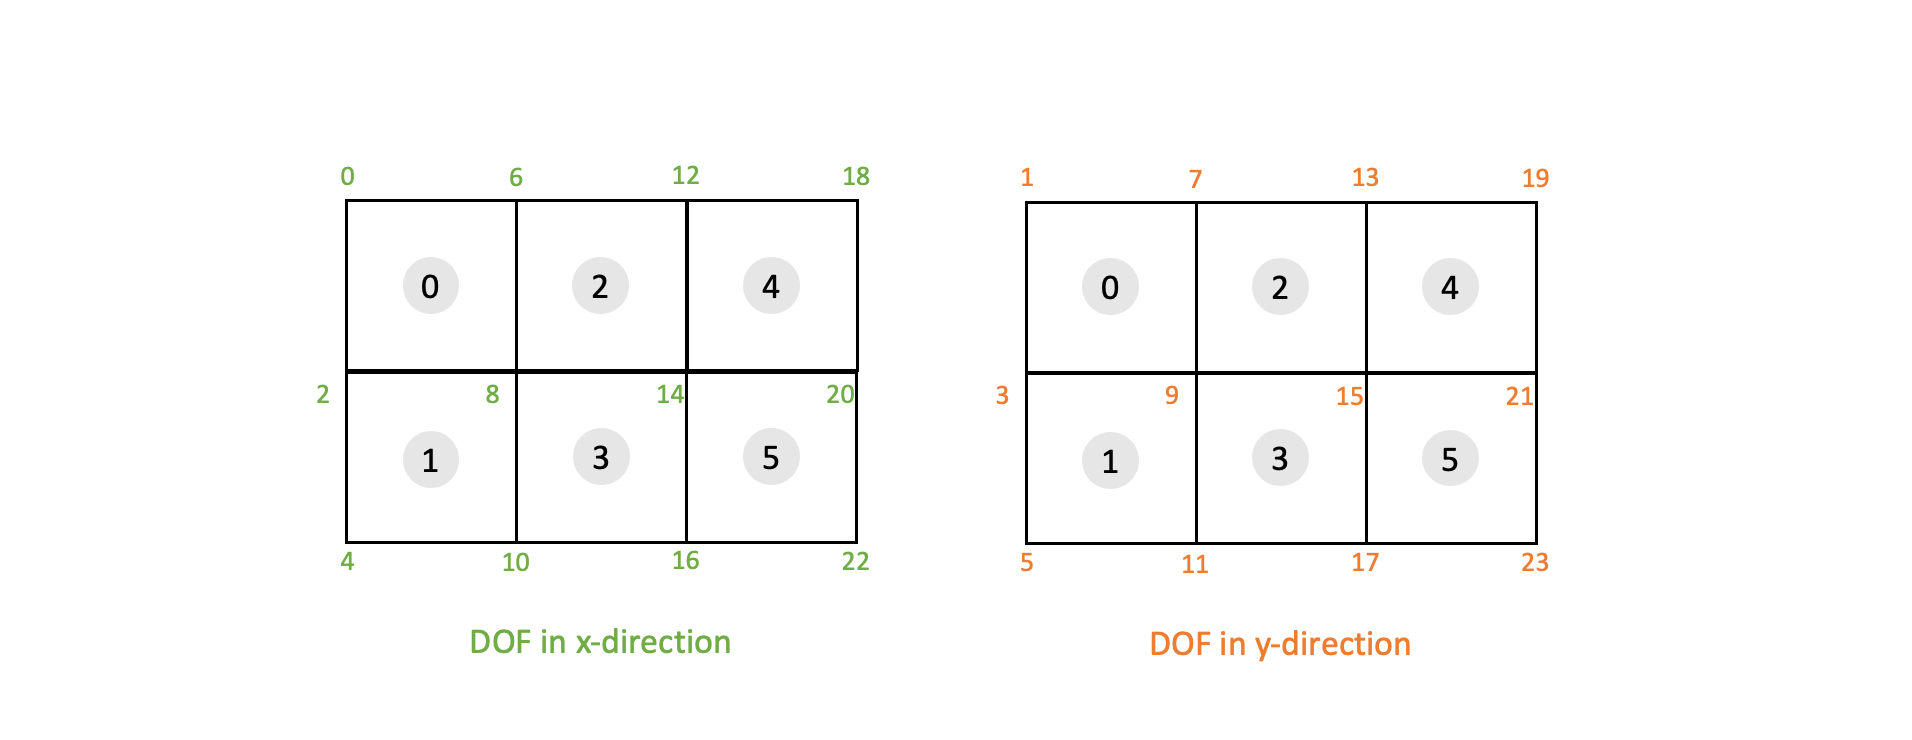

In [ ]:
# FE: Build the index vectors for the coo matrix format.
edofMat=np.zeros((nelx*nely,8),dtype=int)
for elx in range(nelx):
    for ely in range(nely):
        el = ely+elx*nely # element number
        n1=(nely+1)*elx+ely
        n2=(nely+1)*(elx+1)+ely
        edofMat[el,:]=np.array([2*n1+2, 2*n1+3, 2*n2+2, 2*n2+3,2*n2, 2*n2+1, 2*n1, 2*n1+1])

# Construct the index pointers for the coo format
iK = np.kron(edofMat,np.ones((8,1))).flatten()
jK = np.kron(edofMat,np.ones((1,8))).flatten()

# Print
print("DOF indices of each element:\n")
for i in range(len(edofMat)):
    print(f"Element {i}: {edofMat[i]}")

DOF indices of each element:

Element 0: [2 3 8 9 6 7 0 1]
Element 1: [ 4  5 10 11  8  9  2  3]
Element 2: [ 8  9 14 15 12 13  6  7]
Element 3: [10 11 16 17 14 15  8  9]
Element 4: [14 15 20 21 18 19 12 13]
Element 5: [16 17 22 23 20 21 14 15]


### Boundary conditions: load and support

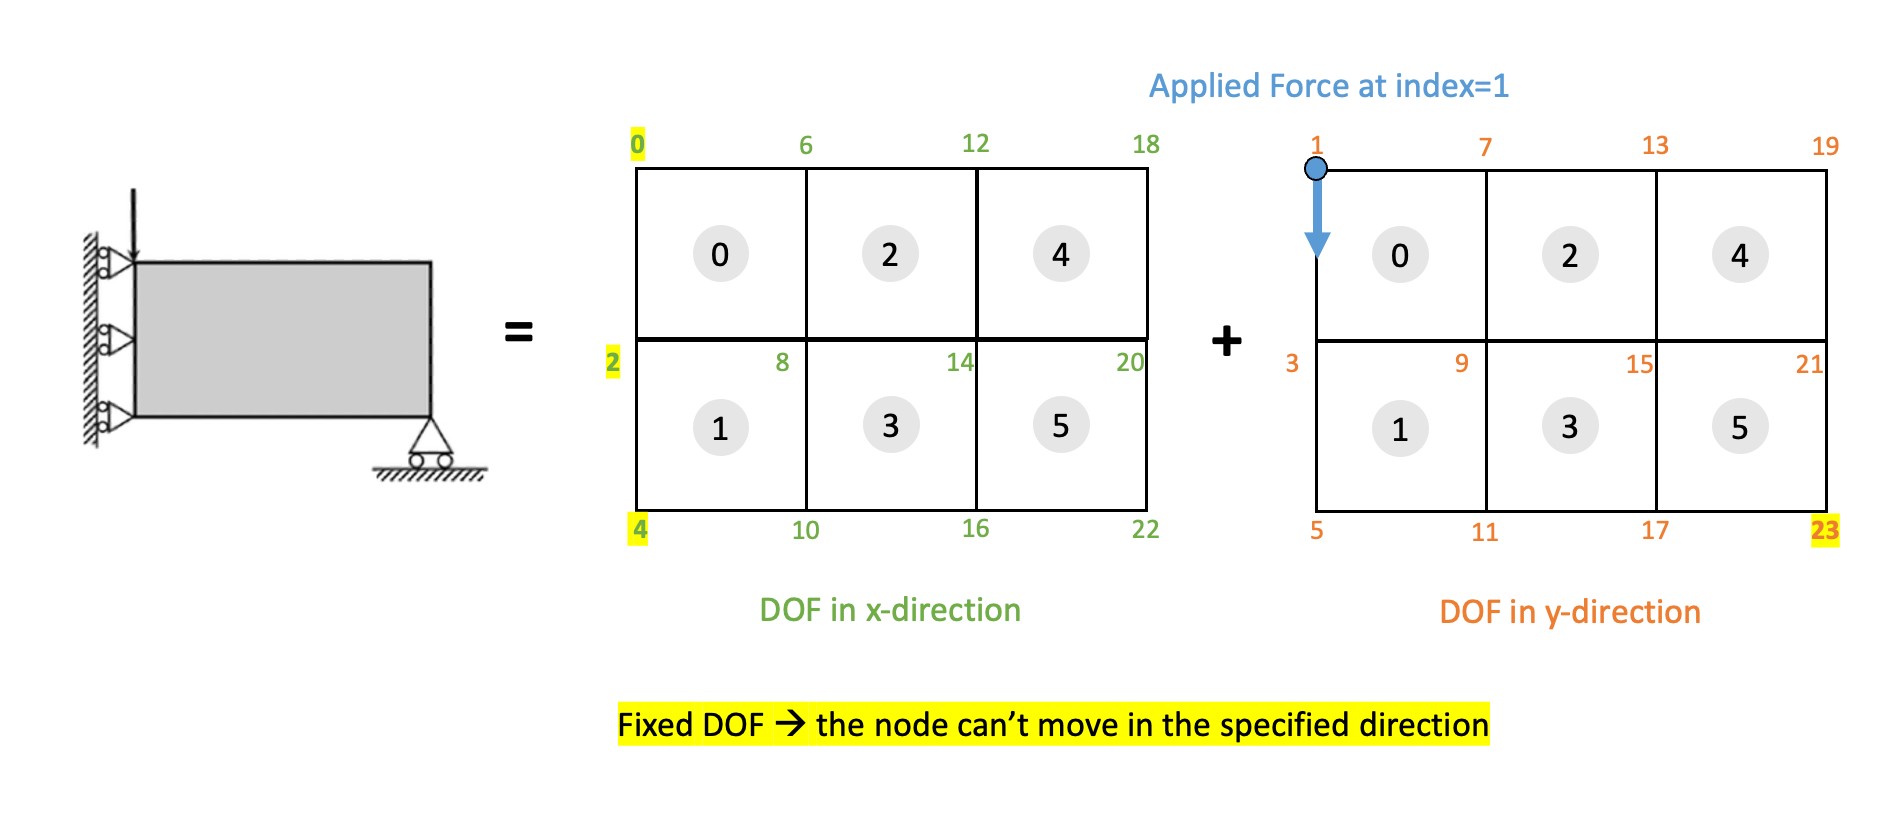

In [ ]:
# BC's and support
dofs=np.arange(2*(nelx+1)*(nely+1))
fixed=np.union1d(dofs[0:2*(nely+1):2],np.array([2*(nelx+1)*(nely+1)-1]))
free=np.setdiff1d(dofs,fixed)

# Solution and RHS vectors
f=np.zeros((ndof,1))
u=np.zeros((ndof,1))

# Set load
f[1,0]=-1

print(f"Fixed DOF indices: {fixed}")
print(f"Free DOF indices: {free}\n")

print(f"f is a {f.shape} force vector, initialised based on the loading condition.")
print(f"u is a {u.shape} displacement vector, to be solved in Finite Element Analysis.")

Fixed DOF indices: [ 0  2  4 23]
Free DOF indices: [ 1  3  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]

f is a (24, 1) force vector, initialised based on the loading condition.
u is a (24, 1) displacement vector, to be solved in Finite Element Analysis.


### Checkboard filter

Topology optimisation is susceptible to the checkboard pattern. The formation of alternating solid and void elements will lead to a design with artificially high stiffness, but not manufacturable. Filtering scheme could be applied to resolve the problem, controlled by the input parameter "rmin". The value of rmin should be adjusted accordingly when the number of elements changes.

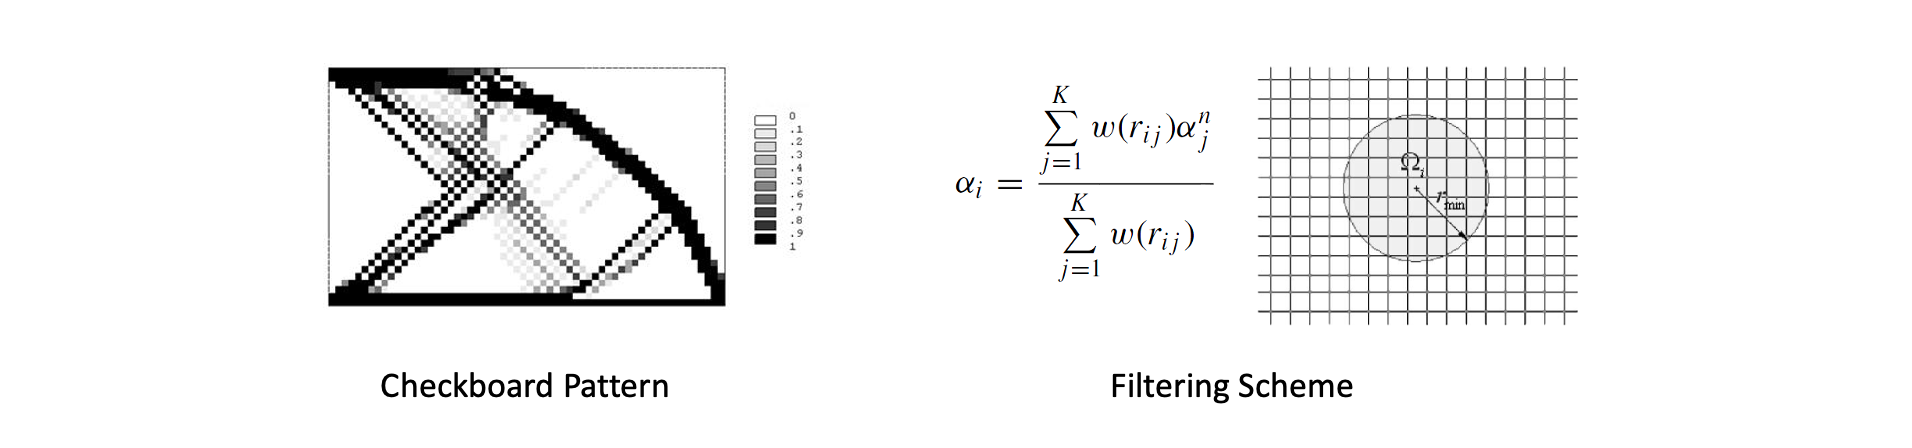

In [ ]:
# Filter: Build (and assemble) the index+data vectors for the coo matrix format
nfilter=int(nelx*nely*((2*(np.ceil(rmin)-1)+1)**2))
iH = np.zeros(nfilter)
jH = np.zeros(nfilter)
sH = np.zeros(nfilter)
cc=0
for i in range(nelx):
    for j in range(nely):
        row=i*nely+j
        kk1=int(np.maximum(i-(np.ceil(rmin)-1),0))
        kk2=int(np.minimum(i+np.ceil(rmin),nelx))
        ll1=int(np.maximum(j-(np.ceil(rmin)-1),0))
        ll2=int(np.minimum(j+np.ceil(rmin),nely))
        for k in range(kk1,kk2):
            for l in range(ll1,ll2):
                col=k*nely+l
                fac=rmin-np.sqrt(((i-k)*(i-k)+(j-l)*(j-l)))
                iH[cc]=row
                jH[cc]=col
                sH[cc]=np.maximum(0.0,fac)
                cc=cc+1

# Finalise assembly and convert to csc format
H=coo_matrix((sH,(iH,jH)),shape=(nelx*nely,nelx*nely)).tocsc()
Hs=H.sum(1)

### Initialise design variables and sensitivity matrix

In [ ]:
# Allocate design variables (as array), initialise and allocate sens.
x=volfrac * np.ones(nely*nelx,dtype=float)
xold=x.copy()
xPhys=x.copy()
g=0 # must be initialised to use the NGuyen/Paulino OC approach
dc=np.zeros((nely,nelx), dtype=float)

# Print
print("\nInitialise design variables to the target volume fraction:")
print(x.reshape(nely,nelx))
print("\nInitialise sensitivity matrix to zeros:")
print(dc)


Initialise design variables to the target volume fraction:
[[0.3 0.3 0.3]
 [0.3 0.3 0.3]]

Initialise sensitivity matrix to zeros:
[[0. 0. 0.]
 [0. 0. 0.]]


# **2.3) Iterations**

The optimisation process is iterative. In each iteration, we will assemble the global stiffness matrix and solve for the displacement vector using finite element analysis. Then, objective function and sensitivity will be calculated accordingly. A density-based filter will be applied to deal with the checkboard pattern. In the end, optimality criteria will be adopted as the updating scheme.


The iteration will stop if any one of the following two criterias was met.
1) The change in objective function is smaller than a user-defined threshold.
2) Exceeding the max number of iterations.

For demonstration purpose, we will only go through the first iteration of the optimisation process.

### Initialise the iteration

In [ ]:
# Set loop counter and gradient vectors
loop=0
change=1

dv = np.ones(nely*nelx) # sensitivity of the objective function c with respect to the element densities xe
dc = np.ones(nely*nelx) # sensitivity of the material volume V with respect to the element densities xe
ce = np.ones(nely*nelx) # strain energy

### Assemble global stiffness matrix [$K$]
All the elemental stiffness matrix will be assembled together based on their shared nodes to form a global stiffness matrix [$K$]. <br>
The figure below is just a demonstration. In our example, 6 elemental stiffness matrix will be assembled together.

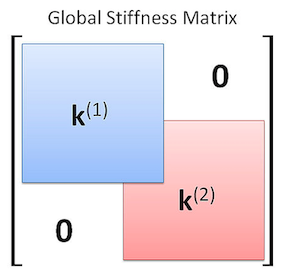

In [ ]:
# Setup and solve FE problem
sK = ((KE.flatten()[np.newaxis]).T*(Emin+(xPhys)**penal*(Emax-Emin))).flatten(order='F')
K = coo_matrix((sK,(iK,jK)),shape=(ndof,ndof)).tocsc()

# Print
print(f"Size of the original global stiffness matrix: {K.shape}" )

Size of the original global stiffness matrix: (24, 24)


Constrained degree of freedom (e.g. fixed support) could be removed from [K] to reduce computational time.

In [ ]:
# Remove constrained dofs from matrix
K = K[free,:][:,free]

# Print
print(f"Fixed DOF indices: {fixed}")
print(f"Number of constrained DOF to be removed: {len(fixed)}")
print(f"Size of the unconstrained global stiffness matrix: {K.shape}" )

Fixed DOF indices: [ 0  2  4 23]
Number of constrained DOF to be removed: 4
Size of the unconstrained global stiffness matrix: (20, 20)


### Solving
### $[K]{u}={f}$

Primary output of finite element analysis is the displacement vector ${u}$, from which strain and stresses etc can be calculated.

- $[K]$ is the global stiffness matrix
- ${u}$ is the displacement vector
- ${f}$ is the load vector

In [ ]:
# Solve system
u[free,0]=spsolve(K,f[free,0])

### Calculate objective and sensitivity

The optimisation objective is to minimise compliance (total strain energy), which is equivalent to maximise stiffness. <br>
Notice the role of SIMP approach in the formulation of the objective function:
$E(x) = E_{\min} + x^p (E_{\max} - E_{\min})$

Sensitivity provides information about how changes in the design variables affect the objective function.

In [ ]:
# Objective and sensitivity
ce[:] = (np.dot(u[edofMat].reshape(nelx*nely,8),KE) * u[edofMat].reshape(nelx*nely,8) ).sum(1)
obj=( (Emin+xPhys**penal*(Emax-Emin))*ce ).sum()
dc[:]=(-penal*xPhys**(penal-1)*(Emax-Emin))*ce
dv[:] = np.ones(nely*nelx)

Sensitivity filtering: density-based

In [ ]:
# Sensitivity filtering
dc[:] = np.asarray(H*(dc[np.newaxis].T/Hs))[:,0]
dv[:] = np.asarray(H*(dv[np.newaxis].T/Hs))[:,0]

### Optimality criteria

Optimality criteria is used to guide the search for an optimal solution.

A convex problem has a global optimal, which is easy to search using the gradient descent approach. However, this is not always the case for topology optimisation. Stochastic aspect helps avoid getting trapped in local minima.

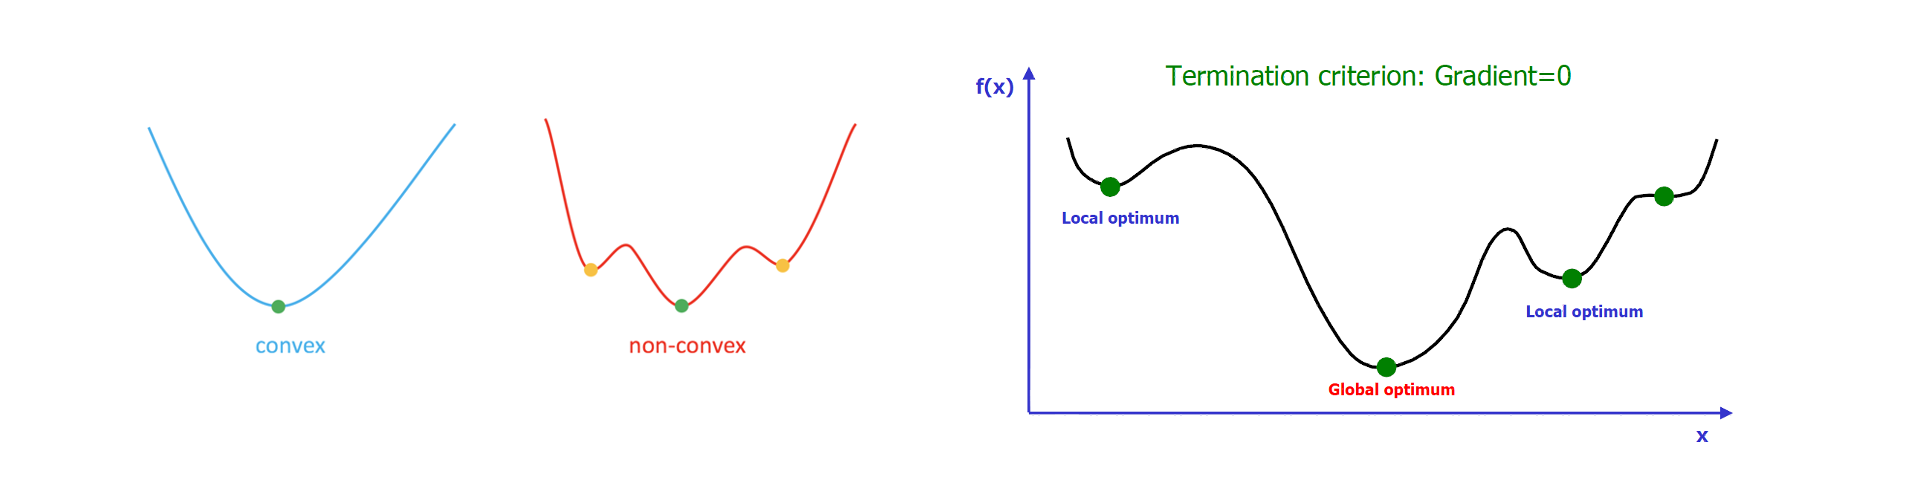

In [ ]:
# Function: optimality criterion
def oc(nelx,nely,x,volfrac,dc,dv,g):
    l1=0
    l2=1e9
    move=0.2
    # reshape to perform vector operations
    xnew=np.zeros(nelx*nely)
    while (l2-l1)/(l1+l2)>1e-3:
        lmid=0.5*(l2+l1)
        xnew[:]= np.maximum(0.0,np.maximum(x-move,np.minimum(1.0,np.minimum(x+move,x*np.sqrt(-dc/dv/lmid)))))
        gt=g+np.sum((dv*(xnew-x)))
        if gt>0 :
            l1=lmid
        else:
            l2=lmid
    return (xnew,gt)

Update design variables

In [ ]:
xold[:]=x
(x[:],g)=oc(nelx,nely,x,volfrac,dc,dv,g)

Filter design variables

In [ ]:
xPhys[:]=np.asarray(H*x[np.newaxis].T/Hs)[:,0]

# Return the optimised design variables
arr = np.round(xPhys.reshape((nelx,nely)).T,2)

print("After the first iteration, relative density at each element:")
print(arr)

print(f"\nTarget density: {volfrac:.4f}")
print(f"Average density: {round(np.mean(xPhys),4)}")

# error in total density value
error= round(abs(np.mean(xPhys)-volfrac)/volfrac*100,2)
print(f"Error in density: {error}%")

After the first iteration, relative density at each element:
[[0.44 0.26 0.14]
 [0.38 0.28 0.29]]

Target density: 0.3000
Average density: 0.2999
Error in density: 0.04%


### Display plot and information of the first iteration

Plot the resulting design variables after the first iteration.

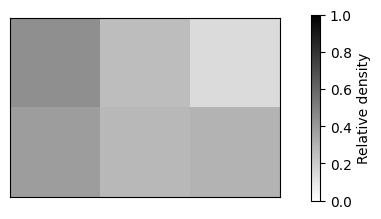

In [ ]:
# Initialise the plot
fig, ax = plt.subplots(figsize=(4, 3))
im = ax.imshow(xPhys.reshape((nelx, nely)).T, cmap='gray_r', interpolation='none', vmin=0.0, vmax=1.0)
cbar = fig.colorbar(im, ax=ax, fraction=0.03, pad=0.1)
cbar.set_label('Relative density')
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
im.set_array(xPhys.reshape((nelx, nely)).T)
fig.canvas.draw()
plt.show()

Display information: iteration number, objective function, volume fraction, change in objective function

In [ ]:
print("iter {0}     obj: {1:.3f}     volfrac: {2:.3f}     change: {3:.3f}".format(\
                    loop+1,obj,(g+volfrac*nelx*nely)/(nelx*nely),change))

iter 1     obj: 675.034     volfrac: 0.300     change: 1.000


------------